In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bomeba0 as bmb
from numba import jit

In [9]:
n = 200
prot = bmb.Protein('A' * n)
ang = np.random.uniform(-180, 180, size=(n, 2))
for i in range(0, len(prot)):
    phi, psi = ang[i]
    prot.set_phi(i, phi)
    prot.set_psi(i, psi)

def fragments(prot):
    """
    Takes a Protein object and returns a list.
    of it's fragmented coordinates.
    ----------------
    Parameters
    ----------------
    prot: Protein object
    
    -----------------
    Returns
    -----------------
    selec: List of selected coordinates.
    """
    xyz = prot.coords
    boxes = bmb.OBB._little_boxes(prot)
    selec =  [xyz.take(i, 0) for i in  boxes]
    return selec

selec = fragments(prot)
frag = np.concatenate(selec)

* Intenté acelerar np.dot(), pero solo logré igualar la velocidad de numpy!
* Al parecer es posible usarla descomposición QR en vez de los autovalores (esto hay que evaluarlo)
* De forma llamativa np.linalg.qr como np.linalg.eigh se pueden acelerar con numba. 

In [10]:
@jit()
def eigh(A):
    return np.linalg.eigh(A)[1]

# https://github.com/danbar/qr_decomposition
@jit
def qr(cov):
    return np.linalg.qr(cov)[0]

@jit
def mini(xyz):
    return np.min(xyz[:,0]), np.min(xyz[:,1]), np.min(xyz[:,2])

@jit
def maxi(xyz):
    return np.max(xyz[:,0]), np.max(xyz[:,1]), np.max(xyz[:,2])

In [11]:
class Node:    
    
    """Constructor to create a new node"""
    
    def __init__(self, coord, parents, children):
        self.obb = vertex_OBB(coord)
        self.parents = parents
        self.children = children
        
    def __str__(self):
        return '{}'.format(self.obb, self.parents, self.children)

def vertex_OBB(XYZ):
        """
        Computes the 8 vertex of the Oriented Bounding Box

        Parameters:
        -----------
        XYZ : array of shape (n,3).
            Contains the coordinates of the atoms to be enclosed by the OBB.  
              

        Returns:
        -----------
        vertex : OBB coordinates
        eigen_vecs : transformation matrix
        vertex_no : XYZ
        """
        # Compute scatter matrix
        scat = np.dot(XYZ.T, XYZ)
        # Compute qr decomposition
        eigen_vecs = qr(scat)
        # Compute eigenvalues
        #eigen_vecs = eigh(scat)
        # project XY onto the "principal axes"
        XYZ_proj = np.dot(XYZ, eigen_vecs)
        # compute min/max values
        min_x, min_y, min_z = mini(XYZ_proj)
        max_x, max_y, max_z = maxi(XYZ_proj)

        Sr = 1.80 #S radius
        min_x, min_y, min_z = min_x - Sr, min_y - Sr, min_z - Sr
        max_x, max_y, max_z = max_x + Sr, max_y + Sr, max_z + Sr
        
        ver_proj_S = np.array([[min_x, min_y, min_z],
                               [min_x, max_y, min_z],
                               [max_x, min_y, min_z],
                               [max_x, max_y, min_z],
                               [min_x, min_y, max_z],
                               [min_x, max_y, max_z],
                               [max_x, min_y, max_z],
                               [max_x, max_y, max_z]])

        # project min/max values back to the original system
        vertex_proj = np.dot(ver_proj_S, eigen_vecs.T)
        #vertex_no = ver_proj @ eigen_vecs.T
        return vertex_proj, eigen_vecs, XYZ
    

def create_nodes(selec):
        """
        Creates every node

        Parameters:
        -----------
        selec : list of arrays containing selection coordinates
        
        Returns:
        -----------
        nodes: (list of lists)
            every level in the hierarchy and every node in each level
        """
        lower_layer = [Node(i, parents=1, children=0) for i in selec]

        combined = combine(lower_layer)
        
        nodes = [lower_layer]

        for _ in selec:
            layer = []
            for node_list in combined:
                if len(node_list) == 1:
                    layer.append(node_list[0])
                else:
                    c = np.concatenate((node_list[0].obb[2], node_list[1].obb[2]))
                    layer.append(Node(c, parents = 1, children = 2))

            combined = combine(layer)
            nodes.append(layer)
            if len(combined[0]) == 1:
                break
        return nodes


def combine(layer):
    """
    group nodes in layer two by two.
    If nodes are odd, the last node will be unpaired.

    Parameters:
    -----------
    layer : list
        list of nodes
    """
    return [layer[n:n+2] for n in range(0, len(layer), 2)]

In [13]:
nodes = create_nodes(selec)

In [14]:
%timeit create_nodes(selec)
%timeit prot.energy()

10 loops, best of 3: 38.3 ms per loop
10 loops, best of 3: 89.7 ms per loop


<IPython.core.display.Javascript object>


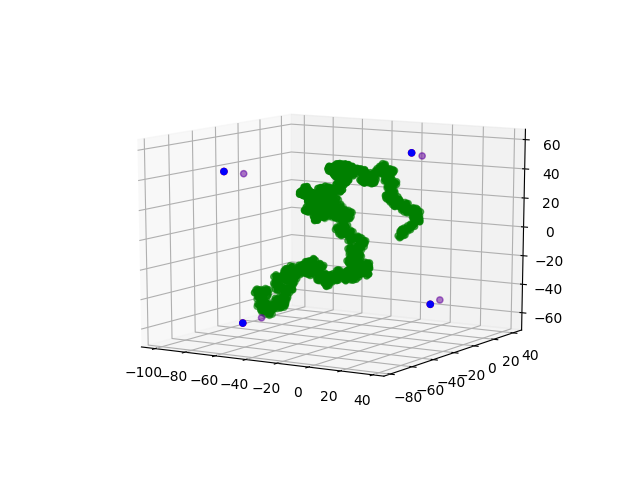

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(frag[:,0], frag[:,1], frag[:,2], c='g')

#ax.scatter(q[:,0], q[:,1], q[:,2], c='m')

lv1 = -1
lv2 = -1
bx = 0
ax.scatter(nodes[lv1][0].obb[0][:,0],  nodes[lv1][0].obb[0][:,1], nodes[lv1][0].obb[0][:,2], c ='r')#
#ax.scatter(nodes[lv2][0].obb[0][:,0],  nodes[lv2][0].obb[0][:,1], nodes[lv2][0].obb[0][:,2], c ='b')#

#ax.scatter(nodes[lv2][bx].obb[0][:,0],  nodes[lv2][bx].obb[0][:,1], nodes[lv2][bx].obb[0][:,2], c ='y')#

#### box for whole protein is the same than the one computed bottom-up
box = vertex_OBB(frag)[0]
ax.scatter(box[:,0] , box[:,1] , box[:,2], c='b')